In [9]:
from luseesky.utils.parse_fits import Beam as luseebeam
import matplotlib.pyplot as plt
import numpy as np

## Visualize original beam

In [2]:
beam = luseebeam("../AntennaSimResults/003_Freq1-50MHz_Delta1MHz_AntennaLength6m_AntennaAngle30deg_LanderHeight2m/"
                 "RadiatedElectricField_AntennaLength6m_AntennaAngle30deg_LanderHeight2m_Phase+0deg.fits")

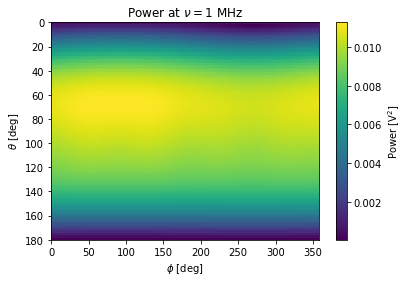

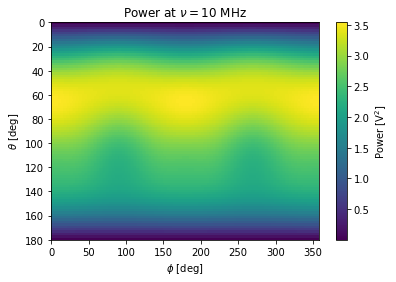

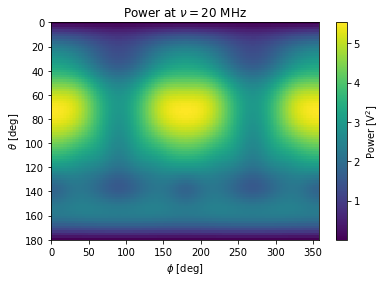

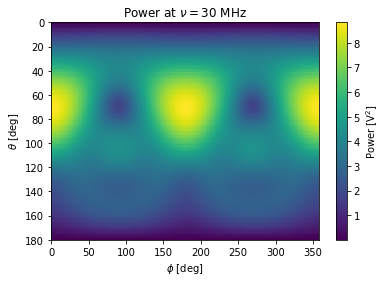

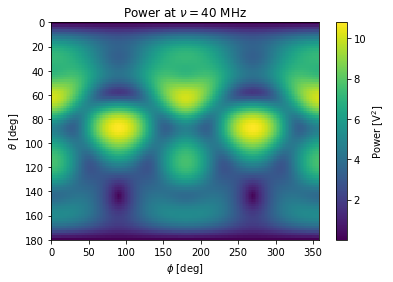

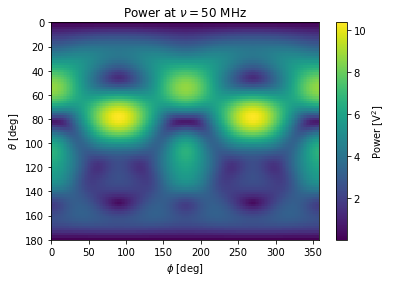

In [3]:
for f in [0, 10, 20, 30, 40, 50]:
    beam.plot_power(f)

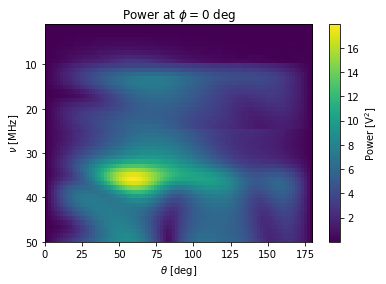

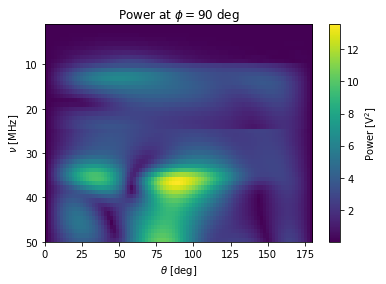

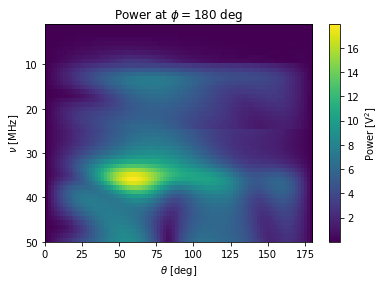

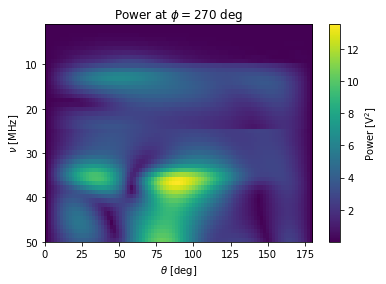

In [4]:
for phi in [0, 90, 180, 270]:
    beam.plot_beamcuts(phi)

## Initialize UVBeam object

In [5]:
uvb = beam.to_uvbeam(verbose=True)

Saving 50 files to ./tmp
Deleting files.
Remove directory ./tmp.


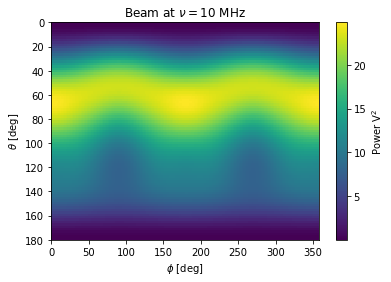

In [17]:
# beam vs phi and theta (data coordinates, extent is [pi/2, 3pi/2, 0, pi])
left, right = np.degrees(uvb.axis1_array).min(), np.degrees(uvb.axis1_array).max()
top, bottom = np.degrees(uvb.axis2_array).min(), np.degrees(uvb.axis2_array).max()
plt.figure()
plt.imshow(uvb.data_array[0,0,0,10], interpolation="none", aspect="auto", extent=[left, right, bottom, top])
plt.title('Beam at $\\nu=10$ MHz')
plt.colorbar(label="Power $\\rm{V}^2$")
plt.xlabel("$\\phi$ [deg]")
plt.ylabel("$\\theta$ [deg]")
plt.show()

In [68]:
# The UVB representation has units of V^2 whereas the original beam has units of V
print(np.allclose(beam.power**2, uvb.data_array[0, 0, 0]))

True


In [146]:
# beampath=os.path.join('../data/uvbeams', DIR, FNAME_BASE+'.uvbeam')
# uvb.write_beamfits(beampath, clobber=True)